# Import

In [1]:
from google.colab import drive
import os
import pandas as pd
import math
import openpyxl
import numpy as np
import warnings
from tqdm.notebook import tqdm
!pip install "camelot-py[cv]" -q
!apt-get install ghostscript
import camelot as cam
!pip install 'PyPDF2<3.0'

from datetime import datetime

# drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/Bank statement'
# files = os.listdir(folder_path)
# files

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ghostscript is already the newest version (9.55.0~dfsg1-0ubuntu5.3).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [2]:
# ocbcfilepath = os.path.join(folder_path, "OCBC", "OCBC_1Sep2022-30Jan2023.csv")
# ocbcfilepath

# OCBC

*   OCBC Savings - 1 September 2022 onwards
*   OCBC Frank - 1 September 2022 onwards

## OCBC Savings

In [3]:
ocbcfilepath = os.path.join(folder_path, "OCBC", "Savings")

In [4]:
def format_ocbc_statement(file_path):
  warnings.filterwarnings("ignore") # Ignore all warnings
  col_names = ["TransactionDate", "ValueDate", "Description", "Withdrawal", "Deposit"]
  # df = pd.read_csv(filename, names=col_names)
  df = pd.read_csv(file_path, names=col_names, skiprows=6)

  # Check if first row contain NaN, if yes, combine the Description column with the previous row
  to_drop = [] # To store the row number with NaN
  for i in range(0,len(df.iloc[:,1])):
    try:
      if math.isnan(df.iloc[i,1]) == True:
        df.iloc[i-1,2] = f"{df.iloc[i-1,2]} ({df.iloc[i,2].strip()})"
        # df = df.drop(i)
        to_drop.append(i)
    except:
      pass

  df.drop(to_drop, axis=0, inplace=True)

  # Make NaN to 0 in Withdrawal and Deposit column
  for i in range(0,len(df.iloc[:,1])):
    try:
      if math.isnan(df.iloc[i,4]) == True: # Deposit column
        df.iloc[i,4] = 0.00
    except:
      pass
    try:
      if math.isnan(df.iloc[i,3]) == True: # Withdrawal column
        df.iloc[i,3] = 0.00
    except:
      pass

  # Remove the ','
  for i in range(0, len(df.Withdrawal)):
    try:
      df['Withdrawal'].iloc[i] = df['Withdrawal'].iloc[i].replace(',','')
    except:
      pass
    try:
      df['Deposit'].iloc[i] = df['Deposit'].iloc[i].replace(',','')
    except:
      pass

  # sum(df['Withdrawal'].astype(float))
  # sum(df['Deposit'].astype(float))

  df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], dayfirst=True) # Change TransactionDate to datetime
  df.iloc[:,1] = pd.to_datetime(df.iloc[:,1], dayfirst=True) # Change ValueDate to datetime
  df.iloc[:,3] = pd.to_numeric(df.iloc[:,3]) # Change withdrawal to float
  df.iloc[:,4] = pd.to_numeric(df.iloc[:,4]) # Change deposit to float
  return df

In [5]:
ocbcsavings_df = pd.DataFrame()
for filename in tqdm(os.listdir(ocbcfilepath)):
    if filename.endswith('.csv'):
        filepath = os.path.join(ocbcfilepath, filename)
        df = format_ocbc_statement(filepath)
        ocbcsavings_df = pd.concat([ocbcsavings_df, df])

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
ocbcsavings_df.head(1)

,TransactionDate,ValueDate,Description,Withdrawal,Deposit
0,2023-01-30,2023-01-30,NETS QR (NETS QR PURCHASE 91146101 EDMOND CHIC...,4.0,0.0


In [7]:
# pd.set_option('display.max_rows', df.shape[0]+1)

## OCBC Frank

In [8]:
frank_filepath = os.path.join(folder_path, "OCBC", "Frank")

In [9]:
ocbcfrank_df = pd.DataFrame()
for filename in tqdm(os.listdir(frank_filepath)):
    if filename.endswith('.csv'):
        filepath = os.path.join(frank_filepath, filename)
        df = format_ocbc_statement(filepath)
        ocbcfrank_df = pd.concat([ocbcfrank_df, df])

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
ocbcfrank_df.head(1)

,TransactionDate,ValueDate,Description,Withdrawal,Deposit
0,2023-01-25,2023-01-25,FUND TRANSFER (OTHR - Other from own account 5...,0.0,300.0


### Saving to Excel

In [11]:
# %cd /content/drive/My Drive/Bank statement
# !pwd

# with pd.ExcelWriter('Sep22-Jun23.xlsx') as writer:
#   ocbcsavings_df.to_excel(writer, sheet_name='OCBC_Savings')
#   ocbcfrank_df.to_excel(writer, sheet_name='OCBC_Frank')

# CIMB

* CIMB - 1 January 2022 onwards

In [12]:
cimb_filepath_2022 = os.path.join(folder_path, "CIMB", "2022")
cimb_filepath_2023 = os.path.join(folder_path, "CIMB", "2023")

In [13]:
def convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%d %b %Y')
    formatted_date = date_obj.strftime('%d/%m/%Y')
    return formatted_date

In [14]:
def format_cimb(filepath, year):
  warnings.filterwarnings("ignore") # Ignore all warnings

  table = cam.read_pdf(filepath, pages='1', flavor='stream')
  df = table[1].df

  # def format_cimb(df):
  # Search for date row
  true_rows = [index for index, value in enumerate(df[0].str.contains('DATE')==True) if value]

  # Trim df to contain only from date row onwards
  df = df.iloc[true_rows[0]:,:]

  # Split the column into two, and move the text to the 2nd column if no separator is found
  df['column_1'] = df[0].apply(lambda x: x.split('\n')[0] if '\n' in x else '')
  df['column_2'] = df[0].apply(lambda x: x.split('\n')[1] if '\n' in x else x)

  df.columns = df.iloc[0] # Make first row as header
  df = df.drop(df.index[0])

  df = df.drop(df.columns[0], axis=1) # Remove first column

  df = df.iloc[:, [-2, -1, 0, 1]] # Rearrange column

  # If the withdrawal and deposit column is empty, move to the left column in the same row and copy the text. Then paste the text to the row above.
  to_drop = [] # Track which column is empty
  for i in range(len(df)-1, 0, -1):
    if df.iloc[i,2]=="" and df.iloc[i,3]=="": # Withdrawal and Deposit column should be empty
      df.iloc[i-1,1] = f"{df.iloc[i-1,1]} {df.iloc[i,1]}"
      to_drop.append(i)

  df = df.reset_index(drop=True)
  df['DATE'] = df['DATE'].replace(r'^\s*$', np.nan, regex=True).fillna(method='ffill')
  df = df.drop(to_drop).reset_index(drop=True) # Remove rows where the text were copied
  df = df.drop([index for index, value in enumerate(df['TRANSACTION DETAILS'].str.contains('Balance brought forward')==True) if value]).reset_index(drop=True)
  df = df.drop([index for index, value in enumerate(df['TRANSACTION DETAILS'].str.contains('Balance carried forward')==True) if value]).reset_index(drop=True)

  # df.drop(df.tail(1).index, inplace=True) # Remove the last row
  # df.drop(df.head(1).index, inplace=True) # Remove the first row

  # Replace empty rows with 0.00
  df['WITHDRAWAL'] = df['WITHDRAWAL'].replace(r'^\s*$', np.nan, regex=True)
  df['DEPOSIT'] = df['DEPOSIT'].replace(r'^\s*$', np.nan, regex=True)
  df['WITHDRAWAL'] = df['WITHDRAWAL'].fillna(value=0.00)
  df['DEPOSIT'] = df['DEPOSIT'].fillna(value=0.00)

  # Remove the ','
  for i in range(0, len(df['DEPOSIT'])):
    try:
      df['DEPOSIT'].iloc[i] = df['DEPOSIT'].iloc[i].replace(',','')
    except:
      pass
    try:
      df['WITHDRAWAL'].iloc[i] = df['WITHDRAWAL'].iloc[i].replace(',','')
    except:
      pass

  # Change data type to float
  df['WITHDRAWAL'] = pd.to_numeric(df['WITHDRAWAL'])
  df['DEPOSIT'] = pd.to_numeric(df['DEPOSIT'])

  # Change the date column from DD MMM to DD/MM/YYYY
  for i in range(0,len(df['DATE'])):
    df['DATE'].loc[i] = f"{df['DATE'].loc[i]} {year}"

  df['DATE'] = df['DATE'].apply(convert_date)
  df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True) # Change TransactionDate to datetime

  return df

In [15]:
cimb_df_2022 = pd.DataFrame()
for filename in tqdm(os.listdir(cimb_filepath_2022)):
    if filename.endswith('.pdf'):
        filepath = os.path.join(cimb_filepath_2022, filename)
        df = format_cimb(filepath, '2022')
        cimb_df_2022 = pd.concat([cimb_df_2022, df])


cimb_df_2023 = pd.DataFrame()
for filename in tqdm(os.listdir(cimb_filepath_2023)):
    if filename.endswith('.pdf'):
        filepath = os.path.join(cimb_filepath_2023, filename)
        df = format_cimb(filepath, '2023')
        cimb_df_2023 = pd.concat([cimb_df_2023, df])

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
cimb_df = pd.concat([cimb_df_2022, cimb_df_2023])
cimb_df.head(1)

,DATE,TRANSACTION DETAILS,WITHDRAWAL,DEPOSIT
0,2022-01-18,IN-HSE 3RD PTY TRF 20220118999636229 SF (31) p...,0.0,5340.0


## Saving to Excel

In [ ]:
# with pd.ExcelWriter('CIMB_2022.xlsx') as writer:
#   cimb_df.to_excel(writer, sheet_name='CIMB')

# Maybank

* Maybank Savings - 1 November 2022 onwards ( to 12 March 23)
* Maybank CC - 1 March 2022 onwards

## Maybank Savings

In [17]:
maybanksavings_filepath = os.path.join(folder_path, "MaybankSavings")
maybanksavings_filepath

'/content/drive/My Drive/Bank statement/MaybankSavings'

In [18]:
def format_maybank_savings(maybanksavings_filepath):
  df = pd.read_csv(maybanksavings_filepath, skiprows=2, header=0, index_col=False)
  # Change data type to float
  df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], dayfirst=True)

  # Replace empty rows with 0.00
  df['Debit'] = df['Debit'].replace(r'^\s*$', np.nan, regex=True)
  df['Debit'] = df['Debit'].fillna(value=0.00)
  df['Credit'] = df['Credit'].replace(r'^\s*$', np.nan, regex=True)
  df['Credit'] = df['Credit'].fillna(value=0.00)

  df['Debit'] = pd.to_numeric(df['Debit'])
  df['Credit'] = pd.to_numeric(df['Credit'])
  return df

In [19]:
maybanksavings_df = pd.DataFrame()
for filename in tqdm(os.listdir(maybanksavings_filepath)):
    if filename.endswith('.csv'):
        filepath = os.path.join(maybanksavings_filepath, filename)
        df = format_maybank_savings(filepath)
        maybanksavings_df = pd.concat([maybanksavings_df, df])

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
maybanksavings_df.head(1)

,Transaction Date,Description,Debit,Credit
0,2023-01-03,VISA Card Pymt EVibes ...,139.85,0.0


## CC

In [21]:
maybankcredit_filepath = os.path.join(folder_path, "MaybankCC")

In [22]:
def mb_convert_date(date_str):
    date_obj = datetime.strptime(date_str, '%d%b %Y')
    formatted_date = date_obj.strftime('%d/%m/%Y')
    return formatted_date

In [23]:
def format_maybankcc(maybankcredit_filepath):
  table = cam.read_pdf(maybankcredit_filepath, pages='1', flavor='stream')
  df = table[1].df
  df = df.drop([1,2]) # remove 2nd and 3rd row
  df.columns = df.iloc[0] # Make first row as header
  df = df.drop(0).reset_index(drop=True)
  df.columns = ["TRANSACTED","POSTED", "DESCRIPTION OF TRANSACTION", "TRANSACTION AMOUNT (S$)" ]
  df['Credit'] = df.iloc[:,3].apply(lambda x: x.split('CR')[0] if 'CR' in x else '0.00')
  df['Debit'] = df.iloc[:,3].apply(lambda x: x.split('CR')[1] if 'CR' in x else x)
  df['Debit'] = df['Debit'].replace(r'^\s*$', np.nan, regex=True).fillna(value=0.00)
  df = df.drop(['TRANSACTION AMOUNT (S$)'], axis=1)

  # Change the date column from DD MMM to DD/MM/YYYY

  if maybankcredit_filepath[-12:-4] == 'Jan_2023':
    for i in range(0,len(df['TRANSACTED'])):
      if df['TRANSACTED'].loc[i][-3:] == 'DEC':
        year = str(int(maybankcredit_filepath[-8:-4]) - 1)
        df['TRANSACTED'].loc[i] = f"{df['TRANSACTED'].loc[i]} {year}"
        df['POSTED'].loc[i] = f"{df['POSTED'].loc[i]} {year}"
      else:
        year = maybankcredit_filepath[-8:-4]
        df['TRANSACTED'].loc[i] = f"{df['TRANSACTED'].loc[i]} {year}"
        df['POSTED'].loc[i] = f"{df['POSTED'].loc[i]} {year}"
  else:
    year = maybankcredit_filepath[-8:-4]
    for i in range(0,len(df['TRANSACTED'])):
      df['TRANSACTED'].loc[i] = f"{df['TRANSACTED'].loc[i]} {year}"
      df['POSTED'].loc[i] = f"{df['POSTED'].loc[i]} {year}"

  df.drop(df[df['DESCRIPTION OF TRANSACTION'] == 'TOTAL TRANSACTION AMOUNT'].index, inplace=True)

  df['TRANSACTED'] = df['TRANSACTED'].apply(mb_convert_date)
  df['TRANSACTED'] = pd.to_datetime(df['TRANSACTED'], dayfirst=True) # Change TransactionDate to datetime
  df['POSTED'] = df['POSTED'].apply(mb_convert_date)
  df['POSTED'] = pd.to_datetime(df['POSTED'], dayfirst=True) # Change TransactionDate to datetime

  df['Debit'] = pd.to_numeric(df['Debit'])
  df['Credit'] = pd.to_numeric(df['Credit'])
  return df

In [24]:
maybankcc_df = pd.DataFrame() # Create empty dataframe
for filename in tqdm(os.listdir(maybankcredit_filepath)): # Filepath folder before .pdf
    if filename.endswith('.pdf'):
        filepath = os.path.join(maybankcredit_filepath, filename)
        df = format_maybankcc(filepath)
        maybankcc_df = pd.concat([maybankcc_df, df]) # Combine dataframe

  0%|          | 0/16 [00:00<?, ?it/s]

## Saving to Excel

In [ ]:
# with pd.ExcelWriter('Maybank_2022.xlsx') as writer:
#   maybankcc_df.to_excel(writer, sheet_name='CIMB')

# Standardising

Adding 'Account' column in each dataframe.

In [25]:
ocbcsavings_df['Account'] = 'OCBCSavings'
ocbcsavings_df = ocbcsavings_df.rename(columns={"Withdrawal":"Debit", "Deposit":"Credit"})
ocbcsavings_df = ocbcsavings_df.iloc[:,[0,2,3,4,5]]
ocbcsavings_df.head(1)

,TransactionDate,Description,Debit,Credit,Account
0,2023-01-30,NETS QR (NETS QR PURCHASE 91146101 EDMOND CHIC...,4.0,0.0,OCBCSavings


In [26]:
ocbcfrank_df['Account'] = 'OCBCFrank'
ocbcfrank_df = ocbcfrank_df.rename(columns={"Withdrawal":"Debit", "Deposit":"Credit"})
ocbcfrank_df = ocbcfrank_df.iloc[:,[0,2,3,4,5]]
ocbcfrank_df.head(1)

,TransactionDate,Description,Debit,Credit,Account
0,2023-01-25,FUND TRANSFER (OTHR - Other from own account 5...,0.0,300.0,OCBCFrank


In [43]:
cimb_df['Account'] = 'CIMB'
cimb_df = cimb_df.rename(columns={"DATE":"TransactionDate", "TRANSACTION DETAILS":"Description", "WITHDRAWAL":"Debit", "DEPOSIT":"Credit"})
cimb_df.iloc[2:3]

,TransactionDate,Description,Debit,Credit,Account
2,2022-01-31,HBH/PFT CREDIT,0.0,4.0,CIMB


In [28]:
maybanksavings_df['Account'] = 'MaybankSavings'
maybanksavings_df = maybanksavings_df.rename(columns={"Transaction Date":"TransactionDate"})
maybanksavings_df.head(1)

,TransactionDate,Description,Debit,Credit,Account
0,2023-01-03,VISA Card Pymt EVibes ...,139.85,0.0,MaybankSavings


In [29]:
maybankcc_df['Account'] = 'MaybankCreditCard'
maybankcc_df = maybankcc_df.rename(columns={"TRANSACTED":"TransactionDate", "DESCRIPTION OF TRANSACTION":"Description"})
maybankcc_df = maybankcc_df.iloc[:,[0,2,4,3,5]]
maybankcc_df.head(1)

,TransactionDate,Description,Debit,Credit,Account
0,2022-03-21,PRIME SPKMT (1996) NTU SINGAPORE,2.0,0.0,MaybankCreditCard


In [37]:
df_all = pd.concat([ocbcsavings_df, ocbcfrank_df, cimb_df, maybanksavings_df, maybankcc_df])
df_all = df_all.sort_values(by='TransactionDate', ascending=False).reset_index(drop=True)
df_all.head(1)

,TransactionDate,Description,Debit,Credit,Account
0,2023-07-01,IB VISA Card Pymt ...,109.46,0.0,MaybankSavings


In [33]:
!pwd

/content/drive/My Drive/Bank statement


In [38]:
with pd.ExcelWriter('Financial_Statement_updated.xlsx') as writer:
  df_all.to_excel(writer, sheet_name='All')

# Read Excel

In [39]:
# df_all = pd.read_excel('Financial_Statement.xlsx').set_index('TransactionDate')# Set first column as the index
df_all = pd.read_excel('Financial_Statement_updated.xlsx')
df_all.head(3)

,Unnamed: 0,TransactionDate,Description,Debit,Credit,Account
0,0,2023-07-01,IB VISA Card Pymt ...,109.46,0.00,MaybankSavings
1,1,2023-06-30,INTEREST CREDIT (),0.00,0.11,OCBCFrank
2,2,2023-06-30,INTEREST CREDIT,0.00,0.07,OCBCSavings


In [40]:
df_all.dtypes

Unnamed: 0                  int64
TransactionDate    datetime64[ns]
Description                object
Debit                     float64
Credit                    float64
Account                    object
dtype: object

In [44]:
# filter by month
month = 1
year = 2023
filtered_df = df_all[(df_all['TransactionDate'].dt.month == month) & (df_all['TransactionDate'].dt.year == year)]

<Axes: xlabel='TransactionDate'>

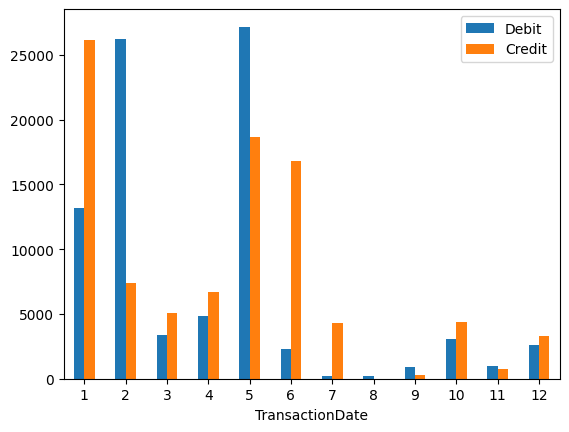

In [45]:
monthly_totals = df_all.groupby(df_all['TransactionDate'].dt.month)[['Debit', 'Credit']].sum()
monthly_totals.plot.bar(rot=0, stacked=False)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

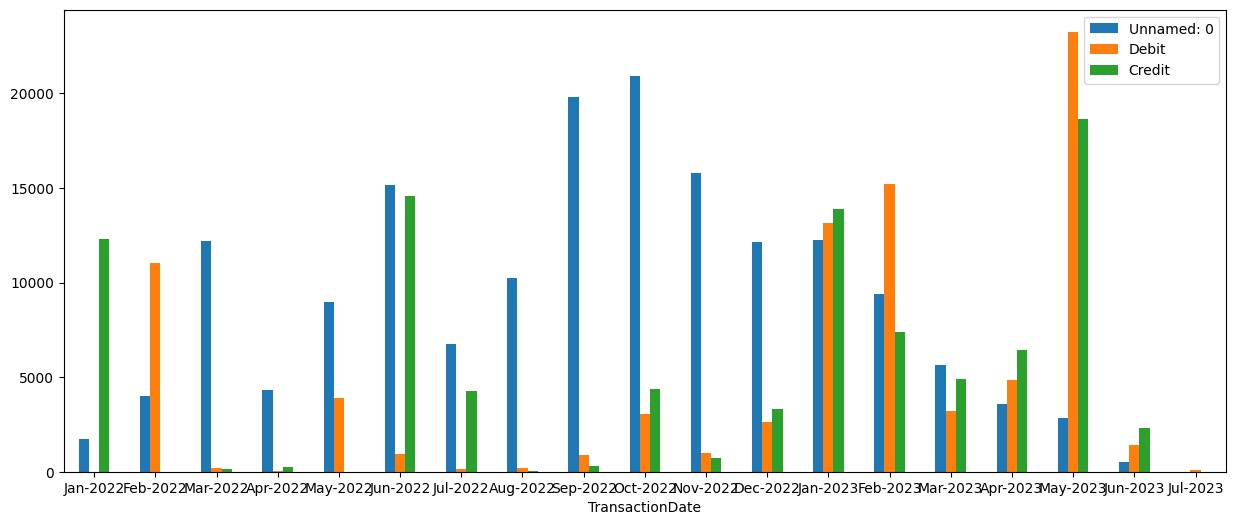

In [47]:
# Group by month and year and calculate the sum of 'Debit' and 'Credit'
monthly_totals = df_all.groupby(df_all['TransactionDate'].dt.to_period('M')).sum()

# Set the figure size to be wider
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the monthly totals
monthly_totals.plot.bar(rot=0, stacked=False, ax=ax)

# Format x-axis labels to include both month and year
x_labels = [f"{d.strftime('%b')}-{d.strftime('%Y')}" for d in monthly_totals.index]
ax.set_xticklabels(x_labels)

# Show the plot
plt.show()